In [1]:
# Cell 1 (v2): Download the LARGER Dataset
import os
import kaggle

# The unique ID for the Kaggle dataset WE CHOSE TO USE
dataset_id = "olegshpagin/llm-detect-ai-train-dataset"

# The local folder where we'll store it
data_path = "data"

# Check if we already have it, if not, download it
if not os.path.exists(data_path):
    print(f"Downloading dataset '{dataset_id}' to '{data_path}'...")
    kaggle.api.dataset_download_files(dataset_id, path=data_path, unzip=True)
    print("✅ Dataset downloaded and unzipped successfully!")
else:
    # If the old data is there, we should clear it out
    import shutil
    shutil.rmtree(data_path)
    os.makedirs(data_path)
    print(f"Old data cleared. Downloading new dataset '{dataset_id}' to '{data_path}'...")
    kaggle.api.dataset_download_files(dataset_id, path=data_path, unzip=True)
    print("✅ New dataset downloaded and unzipped successfully!")


# List the files in the 'data' directory to confirm success
# Use '!dir data' on Windows
!dir data

Old data cleared. Downloading new dataset 'olegshpagin/llm-detect-ai-train-dataset' to 'data'...
Dataset URL: https://www.kaggle.com/datasets/olegshpagin/llm-detect-ai-train-dataset
✅ New dataset downloaded and unzipped successfully!
 Volume in drive C is Boot
 Volume Serial Number is A854-378B

 Directory of C:\Users\gwall\OneDrive\Desktop\Job Search\ML Stuff\LLM Detector\data

07/09/2025  02:31 PM    <DIR>          .
07/09/2025  02:31 PM    <DIR>          ..
07/09/2025  02:31 PM       100,960,902 train_final_41140_rows.csv
               1 File(s)    100,960,902 bytes
               2 Dir(s)  866,438,266,880 bytes free


In [2]:
# Cell 2: Load Data with Pandas and Inspect
import pandas as pd
import os

# Construct the full path to our data file
file_path = os.path.join("data", "train_final_41140_rows.csv")

# Read the CSV file into a pandas DataFrame
# A DataFrame is essentially a powerful, programmable spreadsheet
df = pd.read_csv(file_path)

# --- Initial Inspection ---

# 1. Look at the first 5 rows to understand the columns
print("First 5 rows of the dataset:")
display(df.head())

# 2. Get a summary of the DataFrame (column names, data types, non-null counts)
print("\nDataset Information:")
df.info()

# 3. Check the distribution of our target variable 'label'
# This is CRITICAL for a classification task. 0 = Human, 1 = LLM
print("\nDistribution of labels (0=Human, 1=LLM):")
print(df['label'].value_counts())

First 5 rows of the dataset:


,Unnamed: 0,text,label
0,0,Some schools in United States ofter classes fr...,0.0
1,1,"Four-day work week, a remarkable idea to conse...",0.0
2,2,Students and their families should consider an...,0.0
3,3,Agree you will never grow if something beyond ...,0.0
4,4,I think our character traits are formed by inf...,0.0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41140 entries, 0 to 41139
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  41140 non-null  int64  
 1   text        41140 non-null  object 
 2   label       41140 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 964.3+ KB

Distribution of labels (0=Human, 1=LLM):
label
0.0    20570
1.0    20570
Name: count, dtype: int64


In [3]:
# Cell 3 (v3 - Final Version): Preprocess, Split, and Clean Data
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd # Make sure pandas is imported in this cell if running standalone

# --- 1. Clean the DataFrame ---
# Re-running this part is fine, it just re-does the cleaning.
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore') # 'errors=ignore' prevents error if run twice
df['label'] = df['label'].astype(int)

# --- 2. Split the DataFrame ---
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# --- 3. Convert to Hugging Face Dataset objects ---
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

raw_datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# --- 4. Remove the leftover index column ---
# THIS IS THE CRITICAL LINE THAT FIXES THE OUTPUT
raw_datasets = raw_datasets.remove_columns(['__index_level_0__'])

# --- 5. Inspect the final, clean dataset ---
print("Final Hugging Face Dataset structure:")
print(raw_datasets)

C:\Users\gwall\OneDrive\Desktop\Job Search\ML Stuff\LLM Detector\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Final Hugging Face Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 32912
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8228
    })
})


In [4]:
# Cell 4: Create and Apply Tokenizer
from transformers import AutoTokenizer

# The name of the pre-trained model we are fine-tuning.
# This ensures we use the EXACT same vocabulary and rules as the original model.
model_checkpoint = "distilbert-base-uncased"

# Load the tokenizer.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Now, create a function that will apply the tokenizer to a batch of our data.
def tokenize_function(examples):
    # 'truncation=True' will cut off texts that are longer than the model can handle.
    # 'padding="max_length"' will add empty tokens to shorter texts so all are the same size.
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# The magic line: .map() applies our function to the entire dataset.
# 'batched=True' processes multiple rows at once for speed.
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Let's see what it did. Notice the new columns!
print("\nStructure of the tokenized dataset:")
print(tokenized_datasets)

# We no longer need the original 'text' column, as it's been replaced
# by 'input_ids', 'attention_mask', etc. Let's remove it for cleanliness.
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# The Trainer expects the label column to be named 'labels'. Let's rename it.
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Finally, let's set the format to 'torch' because we're using PyTorch.
# This makes the dataset directly usable by our model.
tokenized_datasets.set_format("torch")

print("\nFinal, model-ready dataset structure:")
print(tokenized_datasets)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8228/8228 [00:02<00:00, 3767.75 examples/s]


Structure of the tokenized dataset:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 32912
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8228
    })
})

Final, model-ready dataset structure:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 32912
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 8228
    })
})


In [5]:
# Cell 5 (v2 - Corrected for modern Transformers library): Configure and Run the Training
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import os

# --- 1. Load the Model ---
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

# --- 2. Define Training Arguments ---
model_name = "llm-detector"
hub_model_id = f"George-Wallden/{model_name}" 

training_args = TrainingArguments(
    output_dir=model_name,
    # --- THIS IS THE FIX ---
    # Renamed 'evaluation_strategy' to 'eval_strategy'
    eval_strategy="epoch",          
    # ----------------------
    save_strategy="epoch",                   # This argument name is still correct
    num_train_epochs=1,                      
    per_device_train_batch_size=16,          
    per_device_eval_batch_size=64,           
    warmup_steps=500,                        
    weight_decay=0.01,                       
    logging_dir='./logs',                    
    logging_steps=10,
    push_to_hub=True,                        
    hub_model_id=hub_model_id,               
    load_best_model_at_end=True,             
)

# --- 3. Initialize the Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

# --- 4. Train! ---
print("Training begins now...")
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\gwall\AppData\Local\Temp\ipykernel_23812\321754937.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training begins now...


Epoch,Training Loss,Validation Loss
1,0.000100,0.008804


TrainOutput(global_step=2057, training_loss=0.05060651961447581, metrics={'train_runtime': 185.4588, 'train_samples_per_second': 177.463, 'train_steps_per_second': 11.091, 'total_flos': 4359767024566272.0, 'train_loss': 0.05060651961447581, 'epoch': 1.0})

In [8]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Making predictions on the validation set...



--- Model Performance ---
Accuracy: 0.9983
F1 Score: 0.9983
-----------------------



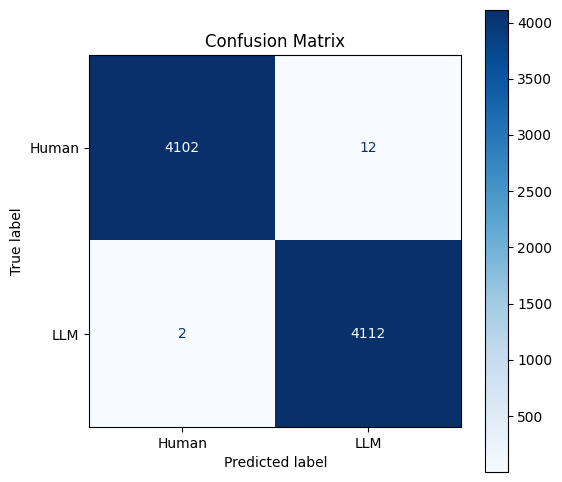

In [9]:
# Cell 6: Evaluate the Model
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- 1. Get Predictions ---
# The trainer.predict() function runs our model on the validation dataset.
print("Making predictions on the validation set...")
predictions_output = trainer.predict(tokenized_datasets["validation"])

# The output contains the model's raw predictions (logits)
# We need to find the class with the highest probability (0 or 1) using argmax
y_preds = np.argmax(predictions_output.predictions, axis=1)

# The output also contains the true labels
y_true = predictions_output.label_ids


# --- 2. Calculate Metrics ---
# Compare the true labels with our model's predictions
accuracy = accuracy_score(y_true, y_preds)
f1 = f1_score(y_true, y_preds)

print(f"\n--- Model Performance ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"-----------------------\n")


# --- 3. Display Confusion Matrix ---
# This matrix shows us what the model got right and what it got wrong.
cm = confusion_matrix(y_true, y_preds)

# Create a beautiful plot for the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "LLM"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Confusion Matrix')
plt.show()

In [10]:
# Cell 7: Final Push to Hub
print("Pushing final model and trainer state to the Hub...")
trainer.push_to_hub("End of training")
print("✅ All files pushed successfully!")

Pushing final model and trainer state to the Hub...
✅ All files pushed successfully!
